<h1><center>Recommender Systems YSDA Course!</center></h1>
<h1><center>Семинар №2</center></h1>

<center><img src="https://github.com/yandexdataschool/recsys_course/blob/2026_spring/week02_candgen/logo.jpg?raw=1" width="500" /></center>

**В этом семинаре мы:**
- Познакомимся с датасетом YAMBDA
- Ссылка на оригинальный датасет: https://huggingface.co/datasets/yandex/yambda
- Посмотрим на контест курса: https://www.kaggle.com/competitions/ysda-rec-sys-2026
- Напишем бейзлайн
- Обучим более сложные модели (CatBoost)
- Напишем несколько новых метрик оценки качества ранжирования

**Баллы за пороги:**
- 5 баллов за пробитие 0.06
- 10 баллов за ...
- 15 баллов за ...
- Топ 3 - дополнительные 10 баллов
- Топ 10 - дополнительные 5 баллов

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 8.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

# 🗄 Датасет:

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "likes.parquet"

data = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect().sample(1000000) # Ограничение для семинара, лучше использовать все данные

data

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid,timestamp,item_id,is_organic
u32,u32,u32,u8
915985,13622040,6084811,0
388160,858685,7600367,1
155505,12572180,6968984,0
941153,25465440,6841746,0
693447,21144995,8897803,0
…,…,…,…
423907,13436765,5829898,1
675041,19728245,4002041,1
105631,15007760,6762323,1


In [4]:
item_ids = data['item_id'].unique()
item_ids

item_id
u32
50
175
198
206
239
…
9390285
9390294
9390323


In [5]:
file_path = "test_users.csv"

test_users = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

test_users

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid
i64
89
153
164
216
291
…
999735
999737
999779


In [6]:
file_path = "artist_item_mapping_small.parquet"

artists = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

artists

100%|██████████| 8.49M/8.49M [00:02<00:00, 4.22MB/s]


artist_id,item_id
u32,u32
2,6990698
4,4427862
5,7240336
8,8639916
12,7016394
…,…
1293380,7614966
1293385,2465805
1293389,1958584


# 👀 Смотрим на датасет, знакомимся

In [7]:
print('min timestamp: ', data['timestamp'].min())
print('max timestamp: ', data['timestamp'].max())

min timestamp:  20
max timestamp:  25999975


In [8]:
print('count days: ', (data.max()['timestamp'] - data.min()['timestamp']).item() / 24 / 60 / 60)

count days:  300.9254050925926


In [9]:
data['uid'].unique().count()

364445

In [10]:
data['item_id'].unique().count()

202223

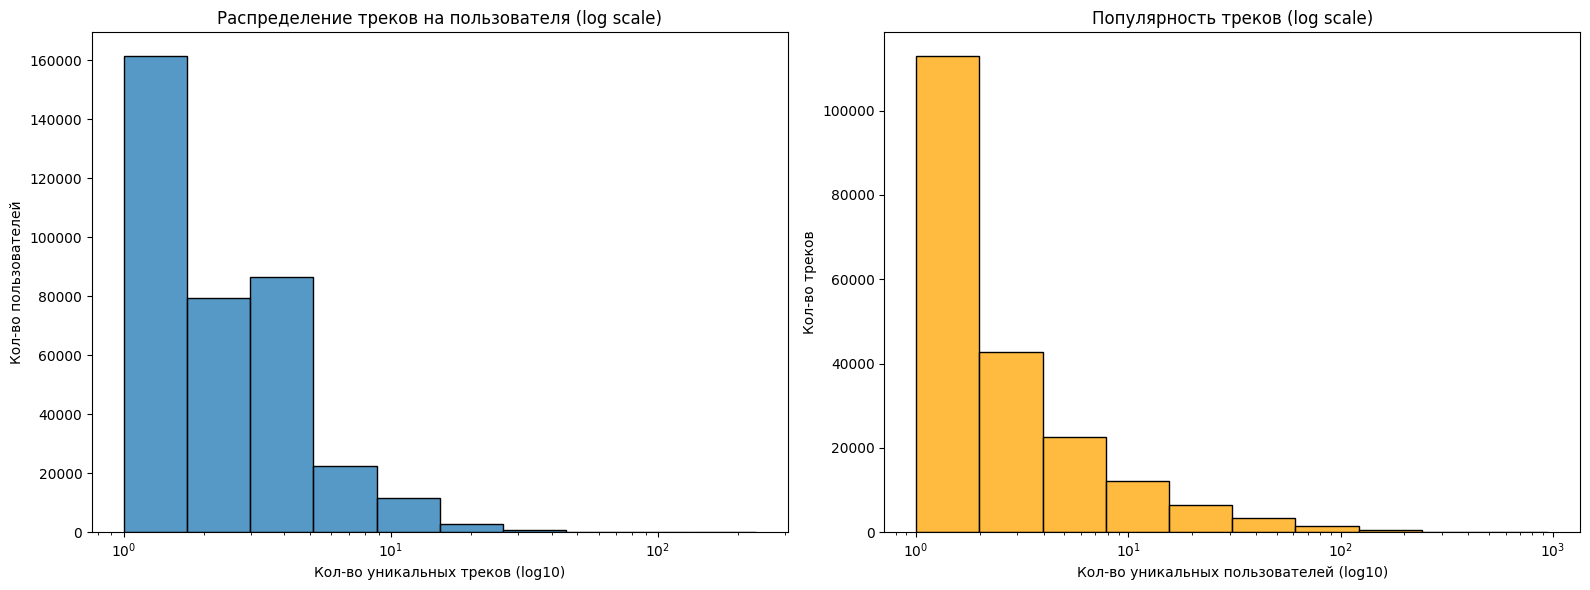

In [11]:
tracks_per_user = data.group_by("uid").agg(
    pl.col("item_id").n_unique().alias("count")
)
users_per_track = data.group_by("item_id").agg(
    pl.col("uid").n_unique().alias("count")
)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=tracks_per_user, x="count", bins=10, ax=ax[0], log_scale=True)
ax[0].set_title("Распределение треков на пользователя (log scale)")
ax[0].set_xlabel("Кол-во уникальных треков (log10)")
ax[0].set_ylabel("Кол-во пользователей")

sns.histplot(data=users_per_track, x="count", bins=10, ax=ax[1], color="orange", log_scale=True)
ax[1].set_title("Популярность треков (log scale)")
ax[1].set_xlabel("Кол-во уникальных пользователей (log10)")
ax[1].set_ylabel("Кол-во треков")

plt.tight_layout()
plt.show()

In [12]:
print('is_organic share: ', data['is_organic'].mean())

is_organic share:  0.576997


# 📈 Бейзлайн: самые лайкаемые треки

In [13]:
popular_tracks = data.group_by(
    'item_id'
).agg(
    pl.len()
).sort('len', descending=True)[:100]['item_id'].to_list()

In [14]:
popular_tracks_strs = []

for i in popular_tracks:
    popular_tracks_strs.append(str(i))

ans = ' '.join(popular_tracks_strs)

test_users = test_users.with_columns(
    pl.lit(ans).alias("item_ids")
)

test_users.write_csv('baseline.csv')

test_users # скор ~ 0.024

uid,item_ids
i64,str
89,"""9378983 6901374 3542184 586296…"
153,"""9378983 6901374 3542184 586296…"
164,"""9378983 6901374 3542184 586296…"
216,"""9378983 6901374 3542184 586296…"
291,"""9378983 6901374 3542184 586296…"
…,…
999735,"""9378983 6901374 3542184 586296…"
999737,"""9378983 6901374 3542184 586296…"
999779,"""9378983 6901374 3542184 586296…"


# 🦾 CatBoost

<center><img src="https://github.com/yandexdataschool/recsys_course/blob/2026_spring/week02_candgen/Timesplit1.svg?raw=1" width="1100" /></center>


Давайте соберём какие-то фичи из данных и обучим на них градиентный бустинг. Нужно не забывать про временные лики. Нельзя давать модели видеть данные из будущего, поэтому фичи для каждого семпла должны быть посчитаны на данных из прошлого. В простейшей схеме предлагается разделить размеченые данные на 3 части:
- Вторая часть - train
- Третья часть - validation
- Первую часть используем для расчёта статистик для трейна
- Для валидации считаем статистики используя первую и вторую части вместе

#### Делим data на 3 части:

In [ ]:
data_len_div3 = int(len(data) / 3)

data = data.sort(
    'timestamp'
)

data_part1 = data[:data_len_div3]
data_part2 = data[data_len_div3:data_len_div3 * 2]
data_part3 = data[data_len_div3 * 2:]

#### Набираем негативы:

In [ ]:
def add_popular_random_negatives(
    pool_df: pl.DataFrame,
    df: pl.DataFrame,
    k: int,
    top_n: int = 10_000,
    seed: int = 42,
) -> pl.DataFrame:
    n = df.height * k

    top_items = (
        pool_df.group_by("item_id").len()
        .sort("len", descending=True)
        .head(top_n)
        .select("item_id")
    )

    neg = pl.DataFrame({
        "uid": pl.concat([df.get_column("uid")] * k, rechunk=True),
        "item_id": top_items.get_column("item_id").sample(n=n, with_replacement=True, seed=seed),
        "target": pl.repeat(0, n, eager=True),
    })

    pos = df.select(["uid", "item_id"]).with_columns(pl.lit(1).alias("target"))
    return pl.concat([pos, neg], how="vertical")


train = add_popular_random_negatives(data_part1, data_part2, 10)
train

uid,item_id,target
u32,u32,i32
361377,8170517,1
864626,7409645,1
133536,1637620,1
779249,8916309,1
905262,3426714,1
…,…,…
987610,7082966,0
219064,327871,0
94710,810937,0


#### Посчитаем популярность трека за прошлый период

In [ ]:
def add_item_popularity(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    pop = train.group_by("item_id").len().rename({"len": "item_popularity"})
    return df.join(pop, on="item_id", how="left").with_columns(
        pl.col("item_popularity").fill_null(0)
    )

train = add_item_popularity(data_part1, train)
train

uid,item_id,target,item_popularity
u32,u32,i32,u32
361377,8170517,1,1
864626,7409645,1,39
133536,1637620,1,15
779249,8916309,1,5
905262,3426714,1,7
…,…,…,…
987610,7082966,0,13
219064,327871,0,7
94710,810937,0,54


#### Кол-во лайков юзера

In [ ]:
def add_user_count_likes(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    pop = train.group_by("uid").len().rename({"len": "user_count_likes"})
    return df.join(pop, on="uid", how="left").with_columns(
        pl.col("user_count_likes").fill_null(0)
    )

train = add_user_count_likes(data_part1, train)
train

uid,item_id,target,item_popularity,user_count_likes
u32,u32,i32,u32,u32
361377,8170517,1,1,0
864626,7409645,1,39,1
133536,1637620,1,15,6
779249,8916309,1,5,0
905262,3426714,1,7,0
…,…,…,…,…
987610,7082966,0,13,1
219064,327871,0,7,0
94710,810937,0,54,1


####  Доля is_organic по треку

In [ ]:
def add_item_organic_share(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    share = train.group_by("item_id").agg(
        pl.col("is_organic").mean().alias("item_organic_share")
    )
    return df.join(share, on="item_id", how="left").with_columns(
        pl.col("item_organic_share").fill_null(0)
    )

train = add_item_organic_share(data_part1, train)
train

uid,item_id,target,item_popularity,user_count_likes,item_organic_share
u32,u32,i32,u32,u32,f64
361377,8170517,1,1,0,0.0
864626,7409645,1,39,1,0.641026
133536,1637620,1,15,6,0.333333
779249,8916309,1,5,0,0.6
905262,3426714,1,7,0,0.428571
…,…,…,…,…,…
987610,7082966,0,13,1,0.692308
219064,327871,0,7,0,0.428571
94710,810937,0,54,1,0.37037


#### Доля is_organic по юзеру

In [ ]:
def add_user_organic_share(train: pl.DataFrame, df: pl.DataFrame) -> pl.DataFrame:
    share = train.group_by("uid").agg(
        pl.col("is_organic").mean().alias("user_organic_share")
    )
    return df.join(share, on="uid", how="left").with_columns(
        pl.col("user_organic_share").fill_null(0)
    )

train = add_user_organic_share(data_part1, train)
train

uid,item_id,target,item_popularity,user_count_likes,item_organic_share,user_organic_share
u32,u32,i32,u32,u32,f64,f64
361377,8170517,1,1,0,0.0,0.0
864626,7409645,1,39,1,0.641026,1.0
133536,1637620,1,15,6,0.333333,0.333333
779249,8916309,1,5,0,0.6,0.0
905262,3426714,1,7,0,0.428571,0.0
…,…,…,…,…,…,…
987610,7082966,0,13,1,0.692308,0.0
219064,327871,0,7,0,0.428571,0.0
94710,810937,0,54,1,0.37037,1.0


In [ ]:
def add_user_artist_like_cnt(events: pl.DataFrame, df: pl.DataFrame, item2artist: pl.DataFrame) -> pl.DataFrame:
    stats = (
        events.select(["uid", "item_id"])
        .join(item2artist, on="item_id", how="left")
        .group_by(["uid", "artist_id"])
        .len()
        .rename({"len": "user_artist_like_cnt"})
    )

    return (
        df.join(item2artist, on="item_id", how="left")
          .join(stats, on=["uid", "artist_id"], how="left")
          .with_columns(pl.col("user_artist_like_cnt").fill_null(0))
          .drop('artist_id')
    )

train = add_user_artist_like_cnt(data_part1, train, artists)
train

uid,item_id,target,item_popularity,user_count_likes,item_organic_share,user_organic_share,user_artist_like_cnt
u32,u32,i32,u32,u32,f64,f64,u32
361377,8170517,1,1,0,0.0,0.0,0
864626,7409645,1,39,1,0.641026,1.0,0
133536,1637620,1,15,6,0.333333,0.333333,0
779249,8916309,1,5,0,0.6,0.0,0
905262,3426714,1,7,0,0.428571,0.0,0
…,…,…,…,…,…,…,…
987610,7082966,0,13,1,0.692308,0.0,0
219064,327871,0,7,0,0.428571,0.0,0
94710,810937,0,54,1,0.37037,1.0,0


#### Проделываем то-же самое для валидации. Фичи считаем по событиям из 2 части датасета. Затем клеим их к 3 части:

In [ ]:
val = add_popular_random_negatives(data_part2, data_part3, 10)
val = add_item_popularity(data_part2, val)
val = add_user_count_likes(data_part2, val)
val = add_item_organic_share(data_part2, val)
val = add_user_organic_share(data_part2, val)
val = add_user_artist_like_cnt(data_part2, val, artists)

val

uid,item_id,target,item_popularity,user_count_likes,item_organic_share,user_organic_share,user_artist_like_cnt
u32,u32,i32,u32,u32,f64,f64,u32
502199,3975793,1,1,0,1.0,0.0,0
121042,6908318,1,7,0,0.428571,0.0,0
230374,5563876,1,3,0,0.666667,0.0,0
559645,6094631,1,45,0,0.377778,0.0,0
276982,3580891,1,0,1,0.0,0.0,0
…,…,…,…,…,…,…,…
308729,7065961,0,11,0,0.272727,0.0,0
959960,6666566,0,92,0,0.554348,0.0,0
342134,3295107,0,17,2,0.294118,0.5,0


#### Обучаем катбуст:

In [ ]:
train_pool = Pool(
    data=train.drop(['target', 'item_id', 'uid']).to_pandas(),
    label=train['target'].to_list(),
)

val_pool = Pool(
    data=val.drop(['target', 'item_id', 'uid']).to_pandas(),
    label=val['target'].to_list(),
)

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=4,
    l2_leaf_reg=10,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=100,
    verbose=10,
    use_best_model=True,
    task_type="GPU",
)

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8301549	best: 0.8301549 (0)	total: 144ms	remaining: 14.3s
10:	test: 0.8583921	best: 0.8586060 (4)	total: 873ms	remaining: 7.06s
20:	test: 0.8582267	best: 0.8599239 (14)	total: 1.61s	remaining: 6.07s
30:	test: 0.8601637	best: 0.8603857 (27)	total: 2.39s	remaining: 5.33s
40:	test: 0.8608685	best: 0.8608685 (40)	total: 3.14s	remaining: 4.52s
50:	test: 0.8613222	best: 0.8613974 (47)	total: 3.91s	remaining: 3.76s
60:	test: 0.8616550	best: 0.8616550 (60)	total: 4.67s	remaining: 2.99s
70:	test: 0.8618140	best: 0.8618140 (70)	total: 5.42s	remaining: 2.21s
80:	test: 0.8619215	best: 0.8619462 (79)	total: 6.17s	remaining: 1.45s
90:	test: 0.8619937	best: 0.8619937 (90)	total: 6.96s	remaining: 689ms
99:	test: 0.8619931	best: 0.8620033 (92)	total: 7.66s	remaining: 0us

bestTest = 0.8620033363
bestIteration = 92

Shrink model to first 93 iterations.


#### Важности фичей:

In [ ]:
imps = model.get_feature_importance(type="PredictionValuesChange")
pairs = sorted(zip(model.feature_names_, imps), key=lambda x: x[1], reverse=True)

for name, val in pairs:
    print(f"{name}: {val}")


item_popularity: 97.37179170359616
item_organic_share: 1.1170690136255765
user_count_likes: 1.0740763774874438
user_artist_like_cnt: 0.2857254950678131
user_organic_share: 0.15133741022300196


### 🔍  Retrieval:

#### Кандидатогенератор популярных треков

In [ ]:
popular_tracks = data.group_by(
    'item_id'
).agg(
    pl.len()
).sort('len', descending=True)[:1000].select(['item_id'])

popular_tracks

item_id
u32
5862961
3542184
9378983
6901374
5463340
…
6756182
6678692
6749531


In [ ]:
test = test_users.select(['uid']).join(popular_tracks, how='cross')

test

uid,item_id
i64,u32
89,5862961
89,3542184
89,9378983
89,6901374
89,5463340
…,…
999884,6756182
999884,6678692
999884,6749531


#### Считаем фичи

In [ ]:
test = add_item_popularity(data_part3, test)
test = add_user_count_likes(data_part3, test)
test = add_item_organic_share(data_part3, test)
test = add_user_organic_share(data_part3, test)
test = add_user_artist_like_cnt(data_part3, test, artists)

test

uid,item_id,item_popularity,user_count_likes,item_organic_share,user_organic_share,user_artist_like_cnt
i64,u32,u32,u32,f64,f64,u32
89,5862961,267,2,0.745318,1.0,0
89,3542184,386,2,0.65544,1.0,0
89,9378983,154,2,0.707792,1.0,0
89,6901374,260,2,0.707692,1.0,0
89,5463340,99,2,0.686869,1.0,0
…,…,…,…,…,…,…
999884,6756182,26,0,0.423077,0.0,0
999884,6678692,42,0,0.5,0.0,0
999884,6749531,27,0,0.518519,0.0,0


#### Применяем модель

In [ ]:
test_pool = Pool(
    data=test.drop(['item_id', 'uid']).to_pandas(),
)

In [ ]:
pred = model.predict_proba(test_pool)[:, 1]

submit = (
    test.select(["uid", "item_id"])
    .with_columns(pl.Series("pred", pred))
    .sort(["uid", "pred"], descending=[False, True])
    .group_by("uid")
    .agg(
        pl.col("item_id").head(100).cast(pl.Utf8).str.join(" ").alias("item_ids")
    )
)

submit

uid,item_ids
i64,str
89,"""7599492 3971215 4899017 736814…"
153,"""7599492 3971215 4899017 647068…"
164,"""7599492 3971215 6470688 736814…"
216,"""3971215 7599492 7368148 489901…"
291,"""3971215 7599492 6470688 489901…"
…,…
999735,"""7599492 3971215 7368148 647068…"
999737,"""3971215 7599492 7368148 489901…"
999779,"""7599492 3971215 6470688 489901…"


In [ ]:
submit.write_csv('catboost.csv') # скор ~ 0.043

### Что дальше?

- Правильная оффлайн валидация (За какие даты собран тест?)
- Правильно собранный пул для обучения
- Больше фичей (Как сделать фичи из эмбеддингов?)
- Более богатые негативы
- Более богатые кандидатогенераторы
- CatBoostClassifier?
- Гиперпараметры модели
- Больше данных
- Учиться на всех данных
<center><img src="https://github.com/yandexdataschool/recsys_course/blob/2026_spring/week02_candgen/Timesplit2.svg?raw=1" width="1100" /></center>

**МОЁ**

In [1]:
!pip install catboost

In [2]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

import kagglehub
from kagglehub import KaggleDatasetAdapter
from collections import defaultdict, Counter
from itertools import combinations


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

likes = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "likes.parquet"
).collect()

test_users = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
    "test_users.csv"
).collect()

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.
Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


In [4]:
likes = likes.select(["uid", "item_id", "timestamp"])

In [5]:
likes = likes.sort("timestamp")

split_ts = likes.select(pl.col("timestamp").quantile(0.8)).item()

train_events = likes.filter(pl.col("timestamp") <= split_ts)
val_events   = likes.filter(pl.col("timestamp") > split_ts)

print(train_events.shape, val_events.shape)

(71467695, 3) (17866910, 3)


In [6]:
TOP_ITEMS = 20000

top_items = (
    train_events
    .group_by("item_id")
    .len()
    .sort("len", descending=True)
    .head(TOP_ITEMS)
    .select("item_id")
)

train_events = train_events.join(top_items, on="item_id", how="inner")

In [7]:
N_LAST = 15

user_recent = (
    train_events
    .sort(["uid", "timestamp"])
    .group_by("uid")
    .tail(N_LAST)
    .select(["uid", "item_id"])
)

In [8]:
user_items = defaultdict(list)

for row in user_recent.iter_rows():
    user_items[row[0]].append(row[1])

In [9]:
pair_counter = Counter()
item_counter = Counter()

for items in user_items.values():
    uniq = list(set(items))

    for i in uniq:
        item_counter[i] += 1

    for i, j in combinations(sorted(uniq), 2):
        pair_counter[(i, j)] += 1

In [ ]:
rows = [(i, j, c) for (i, j), c in pair_counter.items()]

item_item = pl.DataFrame(rows, schema=["item_id", "item_id_right", "cooc"])

/tmp/ipython-input-492705704.py:3: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  item_item = pl.DataFrame(rows, schema=["item_id", "item_id_right", "cooc"])


In [ ]:
item_cnt = pl.DataFrame(
    [(k, v) for k, v in item_counter.items()],
    schema=["item_id", "cnt"]
)

item_item = (
    item_item
    .join(item_cnt.rename({"cnt": "cnt_i"}), on="item_id")
    .join(item_cnt.rename({"item_id": "item_id_right", "cnt": "cnt_j"}), on="item_id_right")
    .with_columns(
        (pl.col("cooc") / (pl.col("cnt_i") * pl.col("cnt_j")).sqrt()).alias("sim")
    )
)

In [ ]:
item_item = (
    item_item
    .sort(["item_id", "sim"], descending=True)
    .group_by("item_id")
    .head(50)
)

In [ ]:
candidates = (
    user_recent
    .join(item_item, on="item_id")
    .select([
        "uid",
        pl.col("item_id_right").alias("item_id"),
        "sim"
    ])
)

In [ ]:
candidates = (
    candidates
    .group_by(["uid", "item_id"])
    .agg(pl.col("sim").sum().alias("score"))
)

In [ ]:
popular = (
    train_events
    .group_by("item_id")
    .len()
    .sort("len", descending=True)
    .head(200)
    .with_columns(pl.lit(0.01).alias("score"))
    .select(["item_id", "score"])
)

In [ ]:
fallback = test_users.join(popular, how="cross")

In [ ]:
all_candidates = pl.concat([
    candidates,
    fallback
])

In [ ]:
submission = (
    all_candidates
    .sort(["uid", "score"], descending=[False, True])
    .group_by("uid")
    .agg(
        pl.col("item_id")
        .head(100)
        .cast(pl.Utf8)
        .str.join(" ")
        .alias("item_ids")
    )
)

In [ ]:
submission = test_users.join(submission, on="uid", how="left")

submission = submission.with_columns(
    pl.col("item_ids").fill_null("-1")
)

In [ ]:
submission.write_csv("submission_1.csv")

**--------**

In [3]:


file_path = "likes.parquet"

data = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

data

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid,timestamp,item_id,is_organic
u32,u32,u32,u8
1,21043915,5258570,1
1,21044560,8055077,1
1,21045095,7447763,1
1,21045530,4995862,1
1,21045530,3791672,1
…,…,…,…
999999,12509560,2627309,1
1000000,14299485,3694666,1
1000000,19336945,7071820,0


In [4]:
file_path = "test_users.csv"

test_users = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

test_users

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


uid
i64
89
153
164
216
291
…
999735
999737
999779


In [5]:
file_path = "artist_item_mapping_small.parquet"

artists = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "thekabeton/ysda-recsys-2026-yambda-dataset/versions/3",
  file_path
).collect()

artists

Using Colab cache for faster access to the 'ysda-recsys-2026-yambda-dataset' dataset.


artist_id,item_id
u32,u32
2,6990698
4,4427862
5,7240336
8,8639916
12,7016394
…,…
1293380,7614966
1293385,2465805
1293389,1958584


In [6]:
data = data.sort("timestamp")

split_ts = data.select(pl.col("timestamp").quantile(0.8)).item()

train_events = data.filter(pl.col("timestamp") <= split_ts)
val_events   = data.filter(pl.col("timestamp") > split_ts)

print(train_events.shape, val_events.shape)

(71467695, 4) (17866910, 4)


In [7]:
TOP_ITEMS = 50000
N_LAST = 20
BATCH = 50000

In [8]:
top_items = (
    train_events
    .group_by("item_id")
    .len()
    .sort("len", descending=True)
    .head(TOP_ITEMS)
    .select("item_id")
)

In [10]:
user_recent = ( train_events .sort(["uid", "timestamp"]) .group_by("uid") .tail(N_LAST) )

In [11]:
user_recent = user_recent.join(top_items, on="item_id", how="inner")

In [12]:
uids = user_recent.select("uid").unique().to_series().to_list()
chunks = [uids[i:i+BATCH] for i in range(0, len(uids), BATCH)]

In [13]:
item_item_parts = []

for chunk in chunks:
    part = user_recent.filter(pl.col("uid").is_in(chunk))

    pairs = (
        part.join(part, on="uid")
        .filter(pl.col("item_id") < pl.col("item_id_right"))
        .group_by(["item_id", "item_id_right"])
        .len()
    )

    item_item_parts.append(pairs)

In [14]:
item_item = pl.concat(item_item_parts)

item_item = (
    item_item
    .group_by(["item_id", "item_id_right"])
    .agg(pl.col("len").sum().alias("cooc"))
)

In [15]:
item_item = (
    item_item
    .sort(["item_id", "cooc"], descending=True)
    .group_by("item_id")
    .head(100)
)

In [16]:
item_cnt = (
    user_recent
    .group_by("item_id")
    .len()
    .rename({"len": "cnt"})
)

item_item = (
    item_item
    .join(item_cnt.rename({"item_id": "item_id", "cnt": "cnt_i"}), on="item_id")
    .join(item_cnt.rename({"item_id": "item_id_right", "cnt": "cnt_j"}), on="item_id_right")
    .with_columns(
        (pl.col("cooc") / (pl.col("cnt_i") * pl.col("cnt_j")).sqrt()).alias("sim")
    )
)

In [ ]:
candidates = (
    user_recent
    .join(item_item, left_on="item_id", right_on="item_id")
    .select(["uid", pl.col("item_id_right").alias("item_id"), "sim"])
)